# Data Science Capstone Project - Battle of the Neighbourhoods
### Applied Data Capstone Project By IBM/Coursera
Written by Andy Edser 20/02/2020

## Table of Contents
- Introduction
- Data
- Methodology
- Analysis 
- Discussion 
- Conclusion 

## Introduction
During the last year of the COVID-19 pandemic the UK has been in various states of lockdowns and travel restrictions. This has meant that many traditional venues for socialising and exercising such as restaurants and gyms have been closed and unavailable for large parts of the year. Due to this, local access to public outdoor facilities and areas such as parks has been at a premium for socially distanced meetups and exercise.

During this year I had to move house. I went from Leamington Spa, Warwickshire and moved north back to my home city of Leeds, West Yorkshire and as a result I have witnessed restrictions in both areas. For my capstone project I will be exploring the access I have had to local public outdoor facilities in both areas I have lived this year to see which area provided the most access, before exploring the city of Leeds as a whole and identifying which areas have the best access to local public outdoor facilities.

This project will be useful for people that may be looking to move to or within the Leeds area and like me will place a premium on local access to public outdoor facilities in the future.

## Data
This problem has been divided into two parts. For both I will consider the following:
- For area I will consider the postcode and its geographical centre by Latitude and Longitude
    - For problem 1 I will use the specific postcodes for each compared area which is known to me
    - For problem 2 I will use postcode data for the entire Leeds area found here: https://en.wikipedia.org/wiki/LS_postcode_area
    - Latitude and Longitude will be retrieved using the Geocoder python package
- I will then use the foursquare API to discover local venues for all of the postcodes
    - Due to restrictions on travel and an encouragement to not drive in the last year I am defining 'Local' as within a 15 minute walk or according to my fitbit approximately 1.5km!
- This data will be combined into a dataframe of postcode, Latitude, Longitude and most common venues before the areas are clustered by common venues.

### Postcode Data
First, lets scrape the required postcode data from wikipedia and get latitude and longitude values to go with it.

In [1]:
import pandas as pd

#Scrape LS Postcodes from Wikipedia
LS_Postcodes = pd.read_html('https://en.wikipedia.org/wiki/LS_postcode_area')[1]

#drop last 3 non-geographic rows
LS_Postcodes = LS_Postcodes.drop(LS_Postcodes.tail(3).index)

#Create dataframe for the lone CV postcode
CV_Postcodes = pd.DataFrame(data = {'Postcode district' : [ 'CV31']})

In [2]:
#Get Latitude and Longitude Data for each postcode
from geopy.geocoders import Nominatim

latitude = []
longitude =[]
for P in LS_Postcodes['Postcode district']:
    address = '{} United Kingdom'.format(P)
    geolocator = Nominatim(user_agent="LS_Explorer")
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

LS_Postcodes['Latitude'] = latitude
LS_Postcodes['Longitude'] = longitude

address = 'CV31, United Kingdom'
geolocator = Nominatim(user_agent="CV31_Explorer")
location = geolocator.geocode(address)

CV_Postcodes['Latitude'] = location.latitude
CV_Postcodes['Longitude'] = location.longitude

In [3]:
#Coords for LS4, LS5, LS15 continuously wrong so manually inputting
LS_Postcodes.at[3, 'Latitude'] = 53.81140
LS_Postcodes.at[3, 'Longitude'] = -1.58167
LS_Postcodes.at[4, 'Latitude'] = 53.82790
LS_Postcodes.at[4, 'Longitude'] = -1.61535
LS_Postcodes.at[14, 'Latitude'] = 53.80703
LS_Postcodes.at[14, 'Longitude'] = -1.43329

In [4]:
#Combine rows for LS18 and CV31 for part 1
df1 = LS_Postcodes.loc[(LS_Postcodes['Postcode district'] == 'LS18')].append(
    CV_Postcodes.loc[(CV_Postcodes['Postcode district']=='CV31')], ignore_index = True)
df1

,Postcode district,Post town,Coverage,Local authority area(s),Latitude,Longitude
0,LS18,LEEDS,Horsforth,Leeds,53.837825,-1.640710
1,CV31,NaN,NaN,NaN,52.280134,-1.534053


### Foursquare Venue Catergories
Since we are restricting the venues to outdoor and public we will next make a list of sub categories in the Outdoor and Recreation Category and remove any that do not apply for filtering later on.

In [5]:
# @hidden_cell
#Foursquare Credentials
CLIENT_ID = '4UG3P30NUYZGLLQPXY2ZF2FXNSWMPEMEHCMD2FJQGU4KMHFQ' # Foursquare ID
CLIENT_SECRET = 'NFA1TAD5NOENGCJ3LGB100R44SFPBU4BPEZY4Q1XMIL43A2X' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
Category_ID = '4d4b7105d754a06377d81259' #outdoor recreation category

In [6]:
#get a list of all the outdoor and recreation primary categories for venue sorting later
import requests # library to handle requests
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            LIMIT)
results = requests.get(url).json()['response']['categories'][5]['categories']
venue_category_list = []
for v in results:
    venue_category_list.append(v['name'])


In [7]:
#List of venue category deemed to be non-public access and remove them from the list
non_public_venues = ['Indoor Play Area', 'Athletics & Sports', 'Stables', 'Palace', 'Recreation Center']
for x in venue_category_list:
    if x in non_public_venues:
        venue_category_list.remove(x)

### Foursquare Venue Search
Next, we will define a function to search for venues around our postcode locations and populate a dataframe 

In [8]:
#create function for getting the nearby venues for postcode in the 'Outdoor and Recreation' category and creating a data frame
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            Category_ID,
            radius, 
            LIMIT)
            
        # make the GET request
        request = requests.get(url)
        json = request.json()
        response = json['response']
        venues = response['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in venues])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
#Venues for part 1
df1_venues = getNearbyVenues(names=df1['Postcode district'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

#remove venues not in the list we defined earlier
df1_venues = df1_venues[df1_venues['Venue Category'].isin(venue_category_list)]

LS18
CV31


In [10]:
#Venues for part 2
df2_venues = getNearbyVenues(names=LS_Postcodes['Postcode district'],
                                   latitudes=LS_Postcodes['Latitude'],
                                   longitudes=LS_Postcodes['Longitude']
                                  )
#remove venues not in the list we defined earlier
df2_venues = df2_venues[df2_venues['Venue Category'].isin(venue_category_list)]

LS1
LS2
LS3
LS4
LS5
LS6
LS7
LS8
LS9
LS10
LS11
LS12
LS13
LS14
LS15
LS16
LS17
LS18
LS19
LS20
LS21
LS22
LS23
LS24
LS25
LS26
LS27
LS28
LS29


## Methodology
In this project so far we have collected the outdoor recreation venue data for the city of Leeds and one postcode in Coventry. We have collected the Location data in Latitude and Longitude format and the venue catergory from Foursquare. The next step will be to analyse the difference between LS18 and CV31 purely on quantity of venues. Followed by the clustering of all Leeds postcodes to identify similar areas with regards to outdoor facility access.

## Analysis

### Part 1 - Exploring the Access to Public Outdoor Recreation Facilities in the Two Areas I have Lived in 2020


In [11]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

In [12]:
#group by postcode and venue category and count
df1_count = df1_venues.groupby(['Postcode','Venue Category']).count().reset_index()

([<matplotlib.axis.YTick at 0x7fe9788a7c50>,
 <a list of 11 Text major ticklabel objects>)

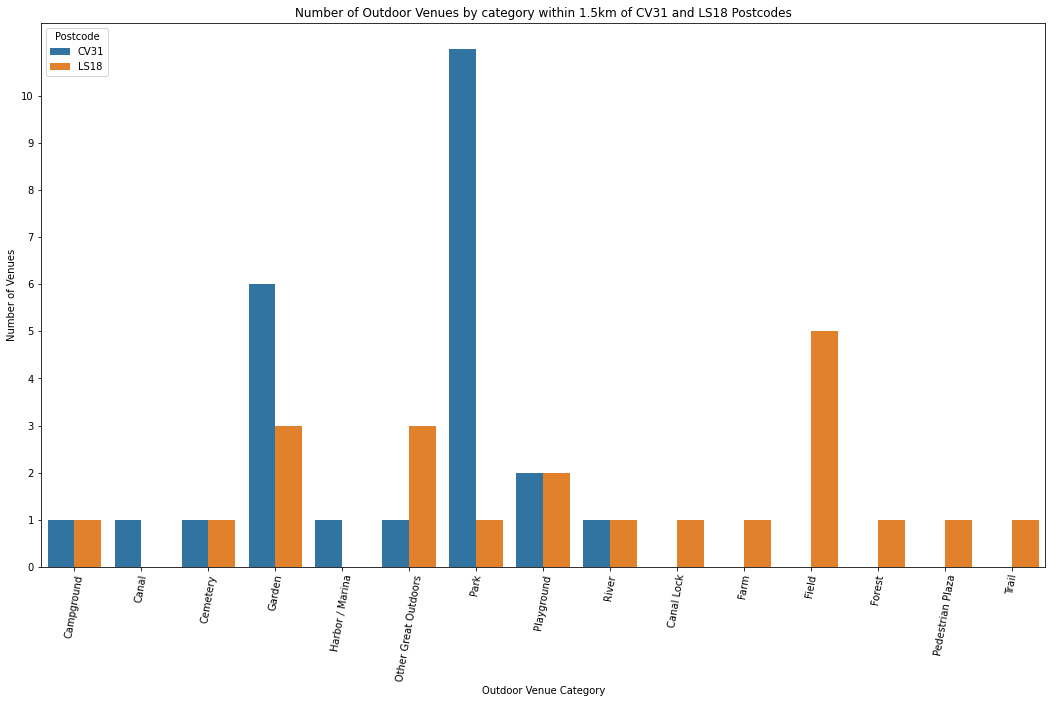

In [13]:
#plot the numbers on a bar graph
plt.figure(figsize=(18, 10))
sns.barplot(x='Venue Category', y="Venue", hue='Postcode', data=df1_count)
plt.xlabel('Outdoor Venue Category')
plt.ylabel('Number of Venues')
plt.title('Number of Outdoor Venues by category within 1.5km of CV31 and LS18 Postcodes')
plt.xticks(rotation=80)
plt.yticks(list(range(0,11,1)))

As we can see from the above graph, CV31 has access to alot more parks and gardens than LS18 which are often the easiest to access outdoor activities. However LS18 has alot more options of venues including a trail, a forest and fields.

### Part 2 - Exploring the Access to Public Outdoor Recreation Facilities in the City of Leeds

In [14]:
# one hot encoding
df2_onehot = pd.get_dummies(df2_venues[['Venue Category']], prefix="", prefix_sep="")

# add Postcode column back to dataframe
df2_onehot['Postcode'] = df2_venues['Postcode'] 

# move Postcode column to the first column
fixed_columns = [df2_onehot.columns[-1]] + list(df2_onehot.columns[:-1])
df2_onehot = df2_onehot[fixed_columns]

df2_onehot.head()

df2_grouped = df2_onehot.groupby('Postcode').mean().reset_index()
df2_grouped

,Postcode,Beach,Bike Trail,Botanical Garden,Bridge,Campground,Canal,Canal Lock,Cemetery,Dog Run,...,Plaza,Pool,Reservoir,River,Rock Climbing Spot,Scenic Lookout,Sculpture Garden,Trail,Vineyard,Well
0,LS1,0.043478,0.000000,0.000000,0.130435,0.000000,0.043478,0.086957,0.000000,0.000000,...,0.217391,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000
1,LS10,0.038462,0.000000,0.000000,0.076923,0.038462,0.038462,0.076923,0.000000,0.000000,...,0.076923,0.000000,0.000000,0.000000,0.000000,0.115385,0.000000,0.000000,0.000000,0.000000
2,LS11,0.040000,0.000000,0.000000,0.040000,0.000000,0.040000,0.080000,0.000000,0.000000,...,0.040000,0.040000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000
3,LS12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,LS13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,...,0.000000,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,LS14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000
6,LS15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000
7,LS16,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.086957,0.043478,...,0.043478,0.043478,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000
8,LS17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000
9,LS18,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.045455,0.045455,0.000000,...,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000


In [15]:
import numpy as np
#get the top 5 most common venues and input to a df
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode district']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Postcodes_venues_sorted = pd.DataFrame(columns=columns)
Postcodes_venues_sorted['Postcode district'] = df2_grouped['Postcode']

for ind in np.arange(df2_grouped.shape[0]):
    Postcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df2_grouped.iloc[ind, :], num_top_venues)

Postcodes_venues_sorted.head()

,Postcode district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,LS1,Plaza,Park,Bridge,Canal Lock,Other Great Outdoors
1,LS10,Other Great Outdoors,Scenic Lookout,Park,Playground,Garden
2,LS11,Other Great Outdoors,Park,Canal Lock,Beach,Field
3,LS12,Park,Other Great Outdoors,Garden,Field,Nature Preserve
4,LS13,Park,Other Great Outdoors,Playground,Hill,Reservoir


In [16]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

df2_grouped_clustering = df2_grouped.drop('Postcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df2_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
Postcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df2_merged = LS_Postcodes

# merge df2_grouped with LS_Postcodes to add latitude/longitude for each Postcode
df2_merged = df2_merged.join(Postcodes_venues_sorted.set_index('Postcode district'), on='Postcode district')

df2_merged.head() # check the last columns!
df2_merged.dropna(inplace = True) #LS24 returned nan which affected the plotting

In [17]:
df2_merged.head()

,Postcode district,Post town,Coverage,Local authority area(s),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,LS1,LEEDS,Leeds city centre,Leeds,53.800839,-1.549712,2.0,Plaza,Park,Bridge,Canal Lock,Other Great Outdoors
1,LS2,LEEDS,"Leeds city centre, Woodhouse",Leeds,53.803777,-1.558412,2.0,Park,Plaza,Pedestrian Plaza,Bridge,Canal Lock
2,LS3,LEEDS,"Burley, Kirkstall, Woodhouse",Leeds,53.801924,-1.561870,2.0,Plaza,Park,Scenic Lookout,Bridge,Pedestrian Plaza
3,LS4,LEEDS,"Burley, Kirkstall",Leeds,53.811400,-1.581670,0.0,Park,Garden,Other Great Outdoors,Well,Nature Preserve
4,LS5,LEEDS,"Hawksworth, Kirkstall",Leeds,53.827900,-1.615350,0.0,Other Great Outdoors,Garden,Canal Lock,Field,Playground


In [18]:
# get coords for Leeds to centre map
geolocator = Nominatim(user_agent="LS_Explorer")
location = geolocator.geocode('Leeds England')
leeds_latitude = location.latitude
leeds_longitude = location.longitude

In [27]:
!pip install folium
import folium # map rendering library

#create map
map_clusters = folium.Map(location=[leeds_latitude, leeds_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df2_merged['Latitude'], df2_merged['Longitude'], df2_merged['Postcode district'], df2_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [20]:
df2_merged.loc[df2_merged['Cluster Labels'] == 0, df2_merged.columns[[0] + list(range(4, df2_merged.shape[1]))]]

,Postcode district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,LS4,53.811400,-1.581670,0.0,Park,Garden,Other Great Outdoors,Well,Nature Preserve
4,LS5,53.827900,-1.615350,0.0,Other Great Outdoors,Garden,Canal Lock,Field,Playground
10,LS11,53.783599,-1.563316,0.0,Other Great Outdoors,Park,Canal Lock,Beach,Field
11,LS12,53.793864,-1.600033,0.0,Park,Other Great Outdoors,Garden,Field,Nature Preserve
12,LS13,53.808608,-1.630938,0.0,Park,Other Great Outdoors,Playground,Hill,Reservoir
15,LS16,53.836672,-1.592715,0.0,Other Great Outdoors,Park,Field,Forest,Cemetery
19,LS20,53.872276,-1.721663,0.0,Other Great Outdoors,Park,Field,Garden,Trail
20,LS21,53.906272,-1.689548,0.0,Park,Playground,Other Great Outdoors,Trail,Garden
21,LS22,53.919912,-1.398356,0.0,Park,Field,Plaza,Bike Trail,River
25,LS26,53.749713,-1.468092,0.0,Farm,Other Great Outdoors,Park,Playground,Garden


### Cluster 2

In [21]:
df2_merged.loc[df2_merged['Cluster Labels'] == 1, df2_merged.columns[[0] + list(range(4, df2_merged.shape[1]))]]

,Postcode district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,LS25,53.830682,-1.351621,1.0,Bridge,Well,Vineyard,Bike Trail,Botanical Garden


### Cluster 3

In [22]:
df2_merged.loc[df2_merged['Cluster Labels'] == 2, df2_merged.columns[[0] + list(range(4, df2_merged.shape[1]))]]

,Postcode district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,LS1,53.800839,-1.549712,2.0,Plaza,Park,Bridge,Canal Lock,Other Great Outdoors
1,LS2,53.803777,-1.558412,2.0,Park,Plaza,Pedestrian Plaza,Bridge,Canal Lock
2,LS3,53.801924,-1.561870,2.0,Plaza,Park,Scenic Lookout,Bridge,Pedestrian Plaza
5,LS6,53.815122,-1.562178,2.0,Park,Garden,Other Great Outdoors,Bridge,Plaza
6,LS7,53.809539,-1.532108,2.0,Plaza,Park,Bridge,Other Great Outdoors,Garden
8,LS9,53.794979,-1.523227,2.0,Plaza,Park,Bridge,Other Great Outdoors,Scenic Lookout
9,LS10,53.782121,-1.535740,2.0,Other Great Outdoors,Scenic Lookout,Park,Playground,Garden
18,LS19,53.844609,-1.689166,2.0,Farm,Park,Field,Scenic Lookout,Bridge


### Cluster 4

In [23]:
df2_merged.loc[df2_merged['Cluster Labels'] == 3, df2_merged.columns[[0] + list(range(4, df2_merged.shape[1]))]]

,Postcode district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,LS14,53.819819,-1.457187,3.0,Field,Playground,Other Great Outdoors,Hill,Cemetery
14,LS15,53.807030,-1.433290,3.0,Field,Playground,Cemetery,Trail,Vineyard
17,LS18,53.837825,-1.640710,3.0,Field,Garden,Other Great Outdoors,Playground,Canal Lock
26,LS27,53.745311,-1.592794,3.0,Playground,Park,Trail,Field,Campground


### Cluster 5

In [24]:
df2_merged.loc[df2_merged['Cluster Labels'] == 4, df2_merged.columns[[0] + list(range(4, df2_merged.shape[1]))]]

,Postcode district,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,LS8,53.839530,-1.512267,4.0,Garden,Playground,Other Great Outdoors,Lake,Scenic Lookout
16,LS17,53.854161,-1.524213,4.0,Garden,Playground,Scenic Lookout,Park,Well
22,LS23,53.903916,-1.348524,4.0,Garden,Dog Run,Bike Trail,Scenic Lookout,River


## Discussion
### Part 1

In [26]:
count = df1_venues.groupby(['Postcode']).count()
count['Venue']

Postcode
CV31    25
LS18    22
Name: Venue, dtype: int64

Part 1 of this report was to explore the access to local public outdoor facilities in CV31 and LS18 postcodes. The table above shows that CV31 had 25 such venues within 1500m and LS18 had 22. Analysis discussed previously showed that of the 25 venues in CV31, 11 were Parks and 6 were garden, Which is fantastic access to those public facilities however LS18 would provide much more choice of options with 13 venue classes available.

### Part 2
For part 2 we investigated the outdoor facilities in the whole of LS18 postcodes and used a clustering algorithm to group the postcodes by similar outdoor facilities. These clusters can be identified by some distinct features.
- Cluster 1 - Mostly contains the outer suburbs of the city and with other stand alone towns like Ilkley and Wetherby. The main category for this cluster is 'Other Great Outdoors' but we can see on the map that the red markers are all close to both the Leeds-Liverpool canal, the river aire and the corresponding nature reserves for the suburbs nearer the city. For the towns like Wetherby, Ilkley and Otley are close to a river (Wharfe in their case) while also being nearer nature expanses such as Ilkley moor.
- Cluster 2 - Cluster 2 only contains one postcode which has some access to outdoor facilities but nothing standout like the rest of the clusters.
- Cluster 3 - The common venue for cluster 3 is a Plaza. This is because all of these postcodes make up the main city centre of Leeds. 
- Cluster 4 - Cluster 4 is very similar to cluster 1 in terms of they are suburbs in the outskirts of the city however are not near to the canal and river.
- Cluster 5 - Cluster 5 contains the suburbs of the more affluent northern surburbs of the city. These have good access to the biggest park and gardens in the city as well as the 1000 acres Harewood estate and Eccup resevoir.

## Conclusion
The purpose of this report was to investigate the access to local public outdoor facilities between CV31 and LS18 and also cluster the postcodes of Leeds into groups with similar level of access. This could be used by people that may be looking for a new area to live and place a premium on these facilities for walking dogs or even just because of the national and local lockdowns to make sure they always have easy access to outdoor space.

We highlighted that on a personal level I had more local facilities in CV31 however they were mostly limited to parks and gardens with more options in LS18 after my move in 2020. We discovered that Leeds can be clustered into 3 distinct types of postcode when it comes to their outdoor access. The city centre, surburbs with local access to the river and canal, and suburbs away from the river and canal which have various accesses to fields or other parks and gardens.